In [1]:
cd ..

/Users/muhammadfarooq/Codebase/thesis-experiment/Pith2Bark


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

# Damage Dataset

In [3]:
def read_damage_min_max(damage_fname):
    df_damage = pd.read_csv(damage_fname)
    
    columns = ['min', 'max', 'mean', 'orig', 'diff_min_max', 'diff_orig_mean', 'damage_mean']
    df_damage_temp = df_damage.drop(columns=columns)
    df_damage_temp.rename(columns={'damage_min_max': 'Damage'}, inplace=True)

    df_damage_temp.reset_index(drop=True, inplace=True)

    return df_damage_temp

In [4]:
def read_damage_mean(damage_fname):
    df_damage = pd.read_csv(damage_fname)
    
    columns = ['min', 'max', 'mean', 'orig', 'diff_min_max', 'diff_orig_mean', 'damage_min_max']
    df_damage_temp = df_damage.drop(columns=columns)
    df_damage_temp.rename(columns={'damage_mean': 'Damage'}, inplace=True)

    df_damage_temp.reset_index(drop=True, inplace=True)

    return df_damage_temp

In [5]:
#damage
damage_sixteen_url = "damage/damage_sixteen.csv"
damage_thirtytwo_url = "damage/damage_thirtytwo.csv"

df_damage_sixteen_min_max = read_damage_min_max(damage_sixteen_url)
df_damage_thirtytwo_min_max = read_damage_min_max(damage_thirtytwo_url)

df_damage_sixteen_mean = read_damage_mean(damage_sixteen_url)
df_damage_thirtytwo_mean = read_damage_mean(damage_thirtytwo_url)

In [6]:
#df_damage_sixteen_min_max

In [7]:
#df_damage_thirtytwo_min_max

In [8]:
#df_damage_sixteen_mean

In [9]:
#df_damage_thirtytwo_mean

In [10]:
#STOP

In [11]:
df = df_damage_sixteen_min_max

In [12]:
#df

In [13]:
# set up the file paths for your image data and labels
img_size = (128, 128)

data_dir = 'damage/images'

# convert the DataFrame to a dictionary with specific column names as key and value
label_dict = {k: v for k, v in zip(df['image'], df['Damage'])}

# create empty lists to store the image data and labels
images = []
labels = []

# loop through each image file in the directory
for filename in os.listdir(data_dir):
    # load the image file and convert it to a NumPy array
    image = load_img(os.path.join(data_dir, filename), target_size=img_size)
    image = img_to_array(image)
    # preprocess the image by scaling the pixel values to be between 0 and 1
    image = image.astype('float32') / 255.0
    # add the preprocessed image and its label to the lists
    images.append(image)
    labels.append(label_dict[filename])

# convert the lists to NumPy arrays
images = np.array(images)
labels = np.array(labels)

# print the shape of the data to verify that it's been loaded correctly
print('Image data shape:', images.shape) #(148, 64, 64, 3)
print('Label data shape:', labels.shape) #(148,)

Image data shape: (148, 128, 128, 3)
Label data shape: (148,)


In [14]:
#STOP

# Config

In [15]:
training_percent = 0.9

epochs, batch_size = 50, 32
kf = KFold(n_splits=3, shuffle=True, random_state=42)

early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        restore_best_weights=True,
    )

METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [16]:
def heat_map(_cm):
    # plot confusion matrix as heatmap
    
    labels = ['Not Damage', 'Damaged']
    
    # Set up the matplotlib figure
    plt.figure(figsize=(4, 3))
    
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    
    sns.heatmap(_cm, annot=True, cmap=cmap, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

In [17]:
def heat_map_n(y_true, y_pred):
    
    class_names = ['Not Damage', 'Damaged']
    
    skplt.metrics.plot_confusion_matrix(y_true, y_pred,
                                        figsize=(4,3),
                                        normalize=True)
    
    # Customize axis tick labels
    plt.xticks([0,1], class_names)
    plt.yticks([0,1], class_names)
    
    plt.yticks(rotation=90)
    
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()

In [18]:
#STOP

# Model

In [19]:
class Baseline():
    def __init__(self, _input_dim, metrics=METRICS):
        # Define the model architecture
        model = Sequential()
        
        # convolutional layer
        model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=_input_dim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))
                  
        # flatten output of conv
        model.add(Flatten())
                  
        # hidden layer
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.2))
        
        # output layer         
        model.add(Dense(1, activation='sigmoid'))

        # Compile the model
        model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=metrics)

        self.model = model

    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        return history
    
    def evaluate(self, X_test, y_test):
        results = self.model.evaluate(X_test, y_test, verbose=0)
        return results

    def predict(self, X_test):
        predictions = self.model.predict(X_test)
        return predictions

    def summary(self):
        self.model.summary()
        
    def metrics_names(self):
        return self.model.metrics_names

# Prepare dataset

In [20]:
X = images
y = labels

# split the data into a holdout set and the rest for K-Fold cross-validation
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, train_size=training_percent, random_state=42)

In [21]:
input_dim = X_train.shape[1:]

model = Baseline(input_dim)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 flatten (Flatten)           (None, 127008)            0         
                                                                 
 dense (Dense)               (None, 64)                8128576   
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

Epoch 1/50
3/3 - 3s - loss: 0.7353 - tp: 28.0000 - fp: 40.0000 - tn: 15.0000 - fn: 5.0000 - accuracy: 0.4886 - precision: 0.4118 - recall: 0.8485 - auc: 0.6333 - prc: 0.5765 - val_loss: 0.4603 - val_tp: 10.0000 - val_fp: 0.0000e+00 - val_tn: 29.0000 - val_fn: 6.0000 - val_accuracy: 0.8667 - val_precision: 1.0000 - val_recall: 0.6250 - val_auc: 0.8297 - val_prc: 0.8287 - 3s/epoch - 836ms/step
Epoch 2/50
3/3 - 1s - loss: 0.4844 - tp: 19.0000 - fp: 2.0000 - tn: 53.0000 - fn: 14.0000 - accuracy: 0.8182 - precision: 0.9048 - recall: 0.5758 - auc: 0.7793 - prc: 0.7714 - val_loss: 0.4511 - val_tp: 10.0000 - val_fp: 3.0000 - val_tn: 26.0000 - val_fn: 6.0000 - val_accuracy: 0.8000 - val_precision: 0.7692 - val_recall: 0.6250 - val_auc: 0.8125 - val_prc: 0.8148 - 561ms/epoch - 187ms/step
Epoch 3/50
3/3 - 1s - loss: 0.4300 - tp: 23.0000 - fp: 4.0000 - tn: 51.0000 - fn: 10.0000 - accuracy: 0.8409 - precision: 0.8519 - recall: 0.6970 - auc: 0.8306 - prc: 0.8213 - val_loss: 0.4807 - val_tp: 10.0000 

Epoch 22/50
3/3 - 1s - loss: 0.2807 - tp: 24.0000 - fp: 1.0000 - tn: 54.0000 - fn: 9.0000 - accuracy: 0.8864 - precision: 0.9600 - recall: 0.7273 - auc: 0.9397 - prc: 0.9345 - val_loss: 0.3679 - val_tp: 10.0000 - val_fp: 0.0000e+00 - val_tn: 29.0000 - val_fn: 6.0000 - val_accuracy: 0.8667 - val_precision: 1.0000 - val_recall: 0.6250 - val_auc: 0.8481 - val_prc: 0.8460 - 549ms/epoch - 183ms/step
Epoch 23/50
3/3 - 1s - loss: 0.2680 - tp: 23.0000 - fp: 0.0000e+00 - tn: 55.0000 - fn: 10.0000 - accuracy: 0.8864 - precision: 1.0000 - recall: 0.6970 - auc: 0.9623 - prc: 0.9566 - val_loss: 0.3699 - val_tp: 10.0000 - val_fp: 0.0000e+00 - val_tn: 29.0000 - val_fn: 6.0000 - val_accuracy: 0.8667 - val_precision: 1.0000 - val_recall: 0.6250 - val_auc: 0.8448 - val_prc: 0.8418 - 525ms/epoch - 175ms/step
Epoch 24/50
3/3 - 1s - loss: 0.2496 - tp: 24.0000 - fp: 0.0000e+00 - tn: 55.0000 - fn: 9.0000 - accuracy: 0.8977 - precision: 1.0000 - recall: 0.7273 - auc: 0.9683 - prc: 0.9619 - val_loss: 0.4157 - 

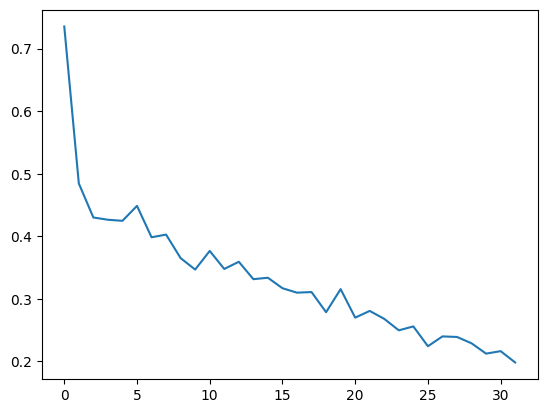

loss :  0.36792153120040894
tp :  10.0
fp :  0.0
tn :  29.0
fn :  6.0
accuracy :  0.8666666746139526
Accuracy on validation set: 0.8666666746139526
precision :  1.0
recall :  0.625
auc :  0.8480603694915771
prc :  0.8459748029708862
Epoch 1/50
3/3 - 2s - loss: 1.1031 - tp: 18.0000 - fp: 14.0000 - tn: 77.0000 - fn: 25.0000 - accuracy: 0.7090 - precision: 0.5625 - recall: 0.4186 - auc: 0.5610 - prc: 0.5866 - val_loss: 0.5163 - val_tp: 16.0000 - val_fp: 3.0000 - val_tn: 19.0000 - val_fn: 6.0000 - val_accuracy: 0.7955 - val_precision: 0.8421 - val_recall: 0.7273 - val_auc: 0.7490 - val_prc: 0.7894 - 2s/epoch - 781ms/step
Epoch 2/50
3/3 - 1s - loss: 0.6042 - tp: 19.0000 - fp: 13.0000 - tn: 49.0000 - fn: 8.0000 - accuracy: 0.7640 - precision: 0.5938 - recall: 0.7037 - auc: 0.8318 - prc: 0.7815 - val_loss: 0.4844 - val_tp: 16.0000 - val_fp: 1.0000 - val_tn: 21.0000 - val_fn: 6.0000 - val_accuracy: 0.8409 - val_precision: 0.9412 - val_recall: 0.7273 - val_auc: 0.7366 - val_prc: 0.7372 - 600ms/

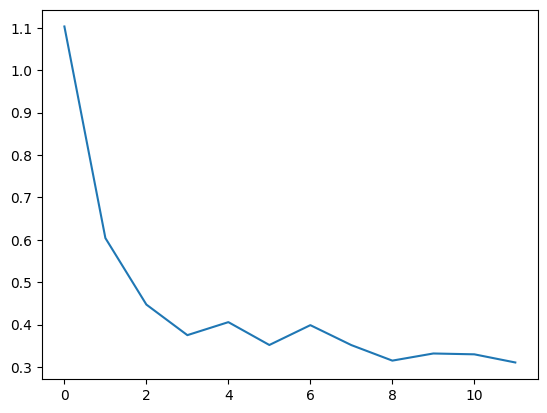

loss :  0.48440656065940857
tp :  16.0
fp :  1.0
tn :  21.0
fn :  6.0
accuracy :  0.8409090638160706
Accuracy on validation set: 0.8409090638160706
precision :  0.9411764740943909
recall :  0.7272727489471436
auc :  0.7365702390670776
prc :  0.7372211217880249
Epoch 1/50
3/3 - 2s - loss: 0.5645 - tp: 37.0000 - fp: 4.0000 - tn: 69.0000 - fn: 23.0000 - accuracy: 0.7970 - precision: 0.9024 - recall: 0.6167 - auc: 0.7939 - prc: 0.8128 - val_loss: 0.3000 - val_tp: 7.0000 - val_fp: 0.0000e+00 - val_tn: 33.0000 - val_fn: 4.0000 - val_accuracy: 0.9091 - val_precision: 1.0000 - val_recall: 0.6364 - val_auc: 0.8567 - val_prc: 0.8471 - 2s/epoch - 768ms/step
Epoch 2/50
3/3 - 1s - loss: 0.4971 - tp: 24.0000 - fp: 2.0000 - tn: 49.0000 - fn: 14.0000 - accuracy: 0.8202 - precision: 0.9231 - recall: 0.6316 - auc: 0.7972 - prc: 0.8227 - val_loss: 0.2791 - val_tp: 8.0000 - val_fp: 1.0000 - val_tn: 32.0000 - val_fn: 3.0000 - val_accuracy: 0.9091 - val_precision: 0.8889 - val_recall: 0.7273 - val_auc: 0.85

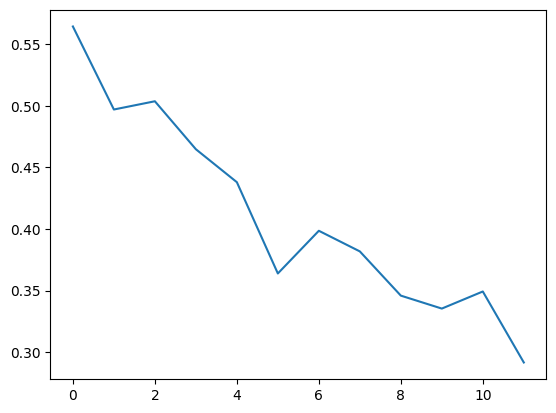

loss :  0.2791365683078766
tp :  8.0
fp :  1.0
tn :  32.0
fn :  3.0
accuracy :  0.9090909361839294
Accuracy on validation set: 0.9090909361839294
precision :  0.8888888955116272
recall :  0.7272727489471436
auc :  0.858126699924469
prc :  0.8475106954574585
results [0.8666666746139526, 0.8409090638160706, 0.9090909361839294]
K-fold cross-validation accuracy: 0.8722222248713175
1/1 [==============================] - 0s 104ms/step
Accuracy on holdout set: 0.8666666666666667
Balanced Accuracy on holdout set: 0.8500000000000001

Classification Report:

              precision    recall  f1-score   support

           0      0.900     0.900     0.900        10
           1      0.800     0.800     0.800         5

    accuracy                          0.867        15
   macro avg      0.850     0.850     0.850        15
weighted avg      0.867     0.867     0.867        15



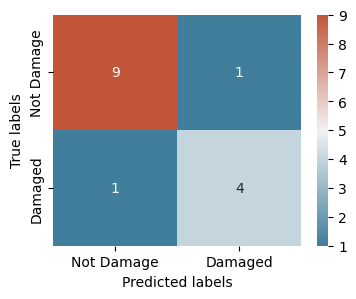

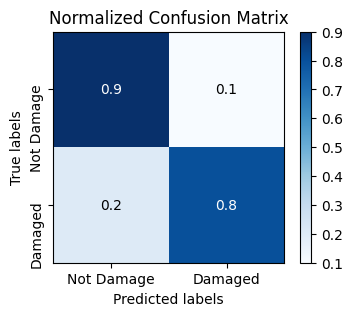

True Positive(TP)  =  4
False Positive(FP) =  1
True Negative(TN)  =  9
False Negative(FN) =  1
Accuracy of the binary classifier = 0.867


In [22]:
results = []

for train_index, val_index in kf.split(X_train):
    # split the dataset into training and validation sets for this fold
    X_train_kf, X_val_kf = X_train[train_index], X_train[val_index]
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]
    
    model = Baseline(input_dim)
    
    history = model.train(X_train_kf, y_train_kf, X_val_kf, y_val_kf, epochs, batch_size)
    plt.plot(history.history['loss'])
    plt.show()
    
    results_m = model.evaluate(X_val_kf, y_val_kf)
    
    for name, value in zip(model.metrics_names(), results_m):
        print(name, ': ', value)
        if name == 'accuracy':
            accuracy_kf = value
            results.append(accuracy_kf)
            print(f"Accuracy on validation set: {accuracy_kf}")
    
# Calculate the average accuracy score for the K-fold cross-validation
print("results",results)
print(f"K-fold cross-validation accuracy: {sum(results) / len(results)}")

y_pred_holdout = model.predict(X_holdout)
accuracy_holdout = accuracy_score(np.round(y_holdout), np.round(y_pred_holdout))
print(f"Accuracy on holdout set: {accuracy_holdout}")

balanced_accuracy_holdout = balanced_accuracy_score(np.round(y_holdout), np.round(y_pred_holdout))
print(f"Balanced Accuracy on holdout set: {balanced_accuracy_holdout}")

print("\nClassification Report:\n")
print(classification_report(np.round(y_holdout), np.round(y_pred_holdout), digits = 3))

cm = confusion_matrix(np.round(y_holdout), np.round(y_pred_holdout))
heat_map(cm)
heat_map_n(np.round(y_holdout), np.round(y_pred_holdout))
TN, FP, FN, TP = confusion_matrix(np.round(y_holdout), np.round(y_pred_holdout)).ravel()
print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

accuracy =  (TP + TN) / (TP + FP + TN + FN)
print('Accuracy of the binary classifier = {:0.3f}'.format(accuracy))

In [23]:
# Calculate performance metrics
accuracy = accuracy_score(np.round(y_holdout), np.round(y_pred_holdout)) * 100
balanced_accuracy = balanced_accuracy_score(np.round(y_holdout), np.round(y_pred_holdout)) * 100
auc = roc_auc_score(np.round(y_holdout), np.round(y_pred_holdout))
precision = precision_score(np.round(y_holdout), np.round(y_pred_holdout))
recall = recall_score(np.round(y_holdout), np.round(y_pred_holdout))
f1 = f1_score(np.round(y_holdout), np.round(y_pred_holdout))

# Print results
print(f"Accuracy: {accuracy:.2f}%")
print(f"Balanced Accuracy: {balanced_accuracy:.2f}%")
print(f"AUC: {auc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 score: {f1:.2f}")

Accuracy: 86.67%
Balanced Accuracy: 85.00%
AUC: 0.85
Precision: 0.80
Recall: 0.80
F1 score: 0.80


In [24]:
#STOP